In [ ]:
!pip install pydicom dicom2nifti nibabel pyradiomics pingouin tensorflow scipy nilearn nipype


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 36.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 20.4 MB/s eta 0:00:00
  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pydicom
import dicom2nifti
import nibabel as nib
from radiomics import featureextractor
import pingouin
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [ ]:
import dicom2nifti

dicom_dir1 = '/content/drive/MyDrive/CTdata/patient1(1.25mm_new)'
dicom_dir2= '/content/drive/MyDrive/CTdata/patient2(5mm_new)'
nifti_output_dir1 = '/content/drive/MyDrive/CTdata/nifticonverted(1mm)'
nifti_output_dir2 = '/content/drive/MyDrive/CTdata/nifticonverted(5mm)'




In [ ]:
dicom2nifti.convert_directory(dicom_dir1, nifti_output_dir1)
dicom2nifti.convert_directory(dicom_dir2, nifti_output_dir2)

In [ ]:
import nibabel as nib
nifti_file_path1 = '/content/drive/MyDrive/CTdata/nifticonverted(1mm)/4_lung_125_mm.nii.gz'
nifti_file_path2 = '/content/drive/MyDrive/CTdata/nifticonverted(5mm)/5_lung_5_mm.nii.gz'
nifti_img1 = nib.load(nifti_file_path1)
nifti_img2 = nib.load(nifti_file_path2)
nifti_data_1mm = nifti_img1.get_fdata()
nifti_data_5mm = nifti_img2.get_fdata()
print(f"Shape of the NIfTI data: {nifti_data_1mm.shape}")
print(f"Shape of the NIfTI data: {nifti_data_5mm.shape}")

Shape of the NIfTI data: (512, 512, 233)
Shape of the NIfTI data: (512, 512, 59)


In [ ]:
header1 = nifti_img1.header
header2 = nifti_img2.header

slice_thickness = header1.get_zooms()[2]
print(f"Slice Thickness: {slice_thickness} mm")
slice_thickness = header2.get_zooms()[2]
print(f"Slice Thickness: {slice_thickness} mm")



Slice Thickness: 1.25 mm
Slice Thickness: 5.0 mm


In [ ]:
print(header1)
`

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 512 512 233   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.        0.640625  0.640625  1.25      1.        1.        1.
  1.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 134.3
qoffset_y       : -242.85938
qoffset_z       : -

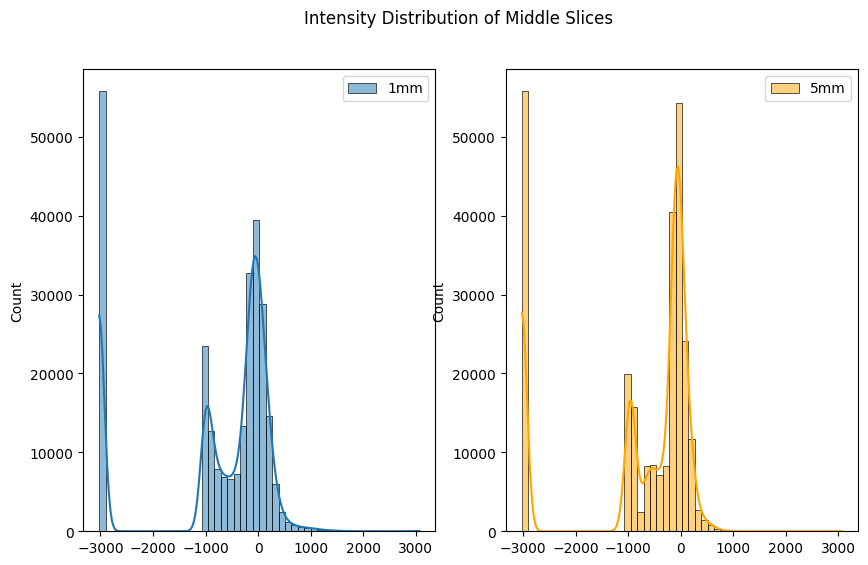

In [ ]:
num_slices1 = nifti_data_1mm.shape[2]
num_slices2 = nifti_data_5mm.shape[2]
middle_slice1 = nifti_data_1mm[:, :, num_slices1//2]
middle_slice2 = nifti_data_5mm[:, :, num_slices2//2]
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
sns.histplot(middle_slice1.flatten(), bins=50, kde=True, ax=axes[0], label='1mm')

sns.histplot(middle_slice2.flatten(), bins=50, kde=True, color='orange', ax=axes[1], label='5mm')
fig.suptitle("Intensity Distribution of Middle Slices")
axes[0].legend()
axes[1].legend()
plt.show()

In [ ]:
# from scipy.stats import pearsonr
# import SimpleITK as sitk

# # Function to extract radiomic features from a single slice
# def extract_radiomic_features_from_slice(image_slice):
#     sitk_image = sitk.GetImageFromArray(image_slice)
#     extractor = featureextractor.RadiomicsFeatureExtractor()
#     features = extractor.execute(sitk_image, sitk_image > 0)  # Use the image itself as the mask
#     return features

# # Load NIfTI images
# def load_nifti_image(nifti_path):
#     nifti_img = nib.load(nifti_path)
#     return nifti_img.get_fdata(), nib.load(nifti_path)

# # Paths to the NIfTI files
# nifti_file_path1 = '/content/drive/MyDrive/CTdata/nifticonverted(1mm)/3_recon_2.nii.gz'
# nifti_file_path2 = '/content/drive/MyDrive/CTdata/nifticonverted(5mm)/3_recon_2.nii.gz'

# # Load the NIfTI images
# nifti_data1, nifti_img1 = load_nifti_image(nifti_file_path1)
# nifti_data2, nifti_img2 = load_nifti_image(nifti_file_path2)

# # Select a specific slice for comparison (e.g., the middle slice)
# middle_slice_index1 = nifti_data1.shape[2]-30
# middle_slice_index2 = nifti_data2.shape[2] -20

# slice_1mm = nifti_data1[:, :, middle_slice_index1]
# slice_5mm = nifti_data2[:, :, middle_slice_index2]

# # Extract radiomic features from the selected slices
# features_1mm = extract_radiomic_features_from_slice(slice_1mm)
# features_5mm = extract_radiomic_features_from_slice(slice_5mm)


# # Filter out non-numeric values and keys to ensure compatibility
# features_1mm_values = [value for key, value in features_1mm.items() if isinstance(value, (int, float))]
# features_5mm_values = [value for key, value in features_5mm.items() if isinstance(value, (int, float))]

# # Ensure both feature sets have the same length for comparison
# min_length = min(len(features_1mm_values), len(features_5mm_values))
# features_1mm_values = features_1mm_values[:min_length]
# features_5mm_values = features_5mm_values[:min_length]

# # Compute CCC for the single slice comparison
# def compute_ccc(x, y):
#     mean_x = np.mean(x)
#     mean_y = np.mean(y)
#     var_x = np.var(x)
#     var_y = np.var(y)
#     pearson_corr, _ = pearsonr(x, y)
#     ccc = (2 * pearson_corr * np.sqrt(var_x) * np.sqrt(var_y)) / (var_x + var_y + (mean_x - mean_y)**2)
#     return ccc

# original_ccc = compute_ccc(features_1mm_values, features_5mm_values)
# print(f"Original CCC: {original_ccc}")

In [ ]:
import numpy as np
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt
from scipy.ndimage import zoom, gaussian_filter

def apply_windowing(data, window_center, window_width):
    lower_limit = window_center - window_width / 2
    upper_limit = window_center + window_width / 2
    windowed_data = np.clip(data, lower_limit, upper_limit)
    return windowed_data

def min_max_scaling(data):
    scaled_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return scaled_data

def resample_image(image, new_spacing=(1, 1, 1)):
    current_spacing = image.header.get_zooms()
    resize_factor = np.array(current_spacing) / np.array(new_spacing)
    new_shape = np.round(image.shape * resize_factor).astype(int)
    smoothed_data = gaussian_filter(image.get_fdata(), sigma=1)

    resampled_data = zoom(smoothed_data, resize_factor, order=3)

    new_affine = np.copy(image.affine)
    for i in range(3):
        new_affine[i, i] = new_spacing[i]
    return nib.Nifti1Image(resampled_data, new_affine)
window_center = -400
window_width = 1500

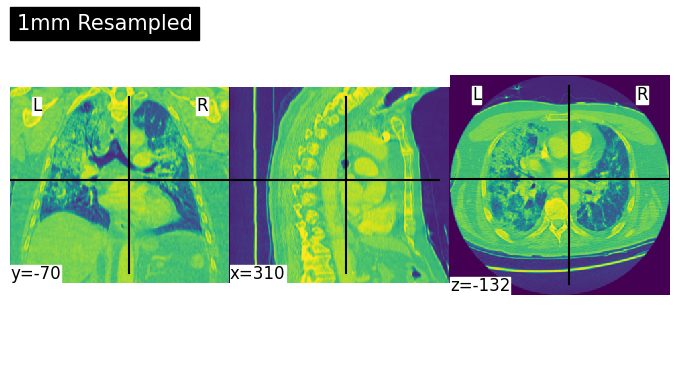

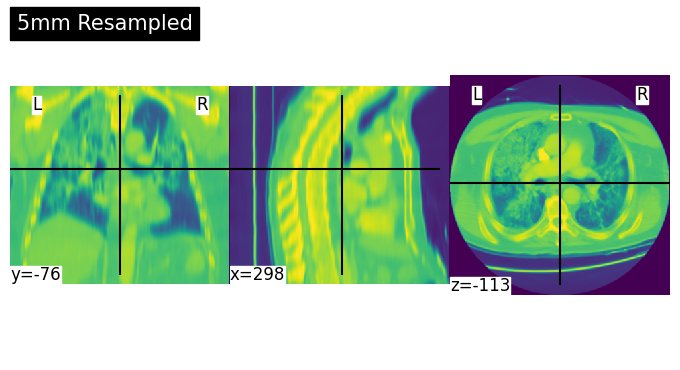

In [ ]:
import numpy as np
import nibabel as nib
from nilearn import plotting, image

nifti_file_path1 = '/content/drive/MyDrive/CTdata/nifticonverted(1mm)/4_lung_125_mm.nii.gz'
nifti_file_path2 = '/content/drive/MyDrive/CTdata/nifticonverted(5mm)/5_lung_5_mm.nii.gz'

nifti_img_1mm = nib.load(nifti_file_path1)
nifti_img_5mm = nib.load(nifti_file_path2)


windowed_img_1mm = apply_windowing(nifti_img_1mm.get_fdata(), window_center, window_width)
windowed_img_5mm = apply_windowing(nifti_img_5mm.get_fdata(), window_center, window_width)

scaled_img_1mm = min_max_scaling(windowed_img_1mm)
scaled_img_5mm = min_max_scaling(windowed_img_5mm)

resampled_img_1mm = resample_image(nib.Nifti1Image(scaled_img_1mm, nifti_img_1mm.affine))
resampled_img_5mm = resample_image(nib.Nifti1Image(scaled_img_5mm, nifti_img_5mm.affine))

plotting.plot_img(resampled_img_1mm, title='1mm Resampled')
plotting.plot_img(resampled_img_5mm, title='5mm Resampled')
plt.show()


In [ ]:
import pydicom
import os

def get_dicom_metadata(dicom_file):
    ds = pydicom.dcmread(dicom_file)
    metadata = {
        'PatientID': ds.PatientID,
        'PatientName': ds.PatientName,
        'PatientBirthDate': ds.PatientBirthDate,
        'PatientSex': ds.PatientSex
    }
    return metadata

# Example usage
dicom_file1 = '/content/drive/MyDrive/CTdata/patient1(1.25mm_new)/4.000000-LUNG 1.25 MM-43946/1-001.dcm'
dicom_file2 = '/content/drive/MyDrive/CTdata/patient2(5mm_new)/5.000000-LUNG 5 MM-52676/1-01.dcm'

dicom_metadata1 = get_dicom_metadata(dicom_file1)
dicom_metadata2 = get_dicom_metadata(dicom_file2)
print(dicom_metadata1)
print(dicom_metadata2)

{'PatientID': 'A002304', 'PatientName': 'A002304', 'PatientBirthDate': '', 'PatientSex': 'M'}
{'PatientID': 'A002304', 'PatientName': 'A002304', 'PatientBirthDate': '', 'PatientSex': 'M'}


##1)Using pre-trained model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
import nibabel as nib
import matplotlib.pyplot as plt

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size//2)

    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        out += residual
        return out

class SuperResolutionModel(nn.Module):
    def __init__(self, upscale_factor=2):
        super(SuperResolutionModel, self).__init__()
        self.prep = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.resblock1 = ResBlock(64, 64)
        self.resblock2 = ResBlock(64, 64)
        self.resblock3 = ResBlock(64, 64)
        self.resblock4 = ResBlock(64, 64)
        self.conv = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.upsample = nn.Conv2d(64, 64 * upscale_factor ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        self.final = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        residual = F.interpolate(x, scale_factor=2, mode='bicubic', align_corners=False)  # Upscale the residual
        out = self.prep(x)
        out = self.resblock1(out)
        out = self.resblock2(out)
        out = self.resblock3(out)
        out = self.resblock4(out)
        out = self.conv(out)
        out = self.upsample(out)
        out = self.pixel_shuffle(out)
        out = self.final(out)
        out += residual
        return out


In [ ]:
def super_resolve_2d_slices(model, image_data):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    high_res_images = []

    with torch.no_grad():
        for i in tqdm(range(image_data.shape[2]), desc="Super-resolving slices"):
            slice_img = Image.fromarray(image_data[:, :, i])
            low_res_tensor = transform(slice_img).unsqueeze(0)# Add batch and channel dimensions
            high_res_tensor = model(low_res_tensor)
            high_res_img = high_res_tensor.squeeze().numpy()  # Remove batch and channel dimensions
            high_res_images.append(high_res_img)

    return np.stack(high_res_images, axis=2)


In [ ]:
import nibabel as nib

def load_nifti_image(file_path):
    img = nib.load(file_path)
    img_data = img.get_fdata()
    return img_data, img.affine, img.header

def save_nifti_image(data, affine, header, output_path):
    new_img = nib.Nifti1Image(data, affine, header)
    nib.save(new_img, output_path)

img_file = '//content/drive/MyDrive/CTdata/high2 resolution.nii.gz'
img = nib.load(img_file)
img_data = img.get_fdata()

model = SuperResolutionModel(upscale_factor=2)

model = model.eval()
high_res_img_data = super_resolve_2d_slices(model, img_data)


Super-resolving slices:   0%|          | 0/1 [00:00<?, ?it/s]


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

(512, 512)

In [ ]:
high_res_img = nib.Nifti1Image(high_res_img_data, img.affine, img.header)
nib.save(high_res_img, '/content/drive/MyDrive/CTdata/high2 resolution.nii.gz')

In [ ]:
high_res_img.shape

(1024, 1024, 59)

In [ ]:
print("Original shape:", img_data.shape)

Original shape: (1024, 1024, 59)


In [ ]:
import matplotlib.pyplot as plt
from nilearn.plotting import plot_img
from nilearn.plotting import plot_anat
from matplotlib.pyplot import  imshow


loaded_super_resolved_nifti_img = nib.load('/content/drive/MyDrive/CTdata/high1 resolution.nii.gz')
img_data = loaded_super_resolved_nifti_img.get_fdata()
windowed_conv_5mm = apply_windowing(loaded_super_resolved_nifti_img.get_fdata(), window_center, window_width)

scaled_conv_5mm = min_max_scaling(windowed_conv_5mm)

# Resample to isotropic voxels
resampled_conv_5mm = resample_image(nib.Nifti1Image(scaled_conv_5mm, nifti_img_1mm.affine))


In [ ]:
from skimage.transform import resize
def plot_slices_side_by_side(img_data1, title1, img_data2, title2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the first image
    z_slice1 = img_data1[:, :, 30]
    im1 = axes[0].imshow(z_slice1.T, cmap="viridis", origin="lower")
    axes[0].set_title(f"{title1} - Z slice")

    # Plot the second image
    z_slice2 = img_data2[:, :, 30]
    im2 = axes[1].imshow(z_slice2.T, cmap="viridis", origin="lower")
    axes[1].set_title(f"{title2} - Z slice")

    plt.show()


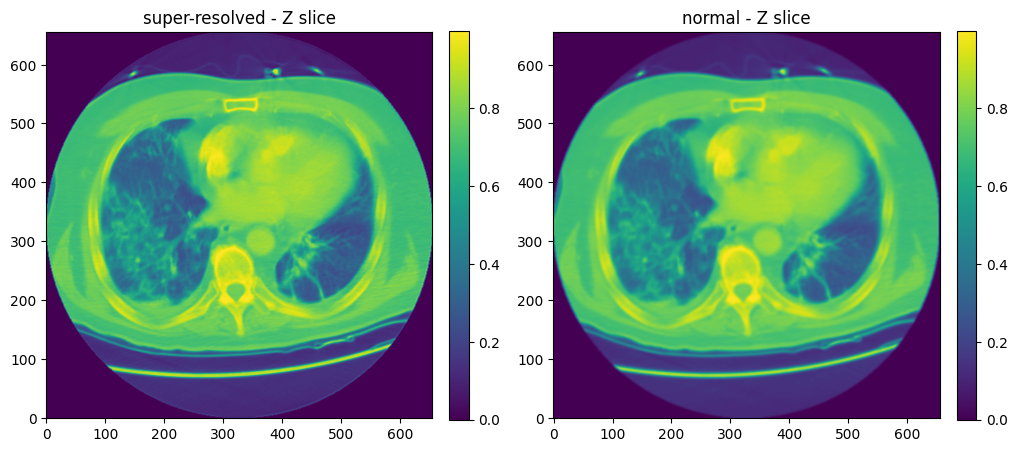

In [ ]:
data_super_resolved = resampled_conv_5mm.get_fdata()
data_normal = resampled_img_5mm.get_fdata()

resized_data_normal5mm = resize(data_normal, data_super_resolved.shape, mode='constant', preserve_range=True)

plot_slices_side_by_side(data_super_resolved, 'super-resolved', resized_data_normal5mm, 'normal')

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr

data_range = data_super_resolved.max() - data_super_resolved.min()
psnr_value1 = psnr(data_super_resolved, resized_data_normal5mm, data_range=data_range1)
print(f"PSNR: {psnr_value1:.2f}")

resized_data_normal1mm = resize(resampled_img_1mm.get_fdata(), data_super_resolved.shape, mode='constant', preserve_range=True)

psnr_value2 = psnr(data_super_resolved,resized_data_normal1mm , data_range=data_range)
print(psnr_value2)

psnr_value3 = psnr(resized_data_normal5mm,resized_data_normal1mm , data_range=data_range)
print(psnr_value3)

PSNR: 33.08
28.981644057953208
29.532920069248235


In [ ]:
import SimpleITK as sitk
import radiomics

def extract_radiomic_features(image_path):
    # Load the image using SimpleITK
    image = sitk.ReadImage(image_path)

    # Create a region of interest (ROI) using BinaryThreshold
    roi = sitk.BinaryThreshold(image, lowerThreshold=0, upperThreshold=1)

    # Extract radiomic features using PyRadiomics
    extractor = radiomics.featureextractor.RadiomicsFeatureExtractor()
    extractor.enableFeatureClassByName('shape')
    extractor.enableFeatureClassByName('firstorder')
    extractor.enableFeatureClassByName('glcm')

    features = extractor.execute(image, roi)

    return features

In [ ]:
nifti_file_path_1mm = '/content/drive/MyDrive/CTdata/nifticonverted(1mm)/4_lung_125_mm.nii.gz'
nifti_file_path_5mm = '/content/drive/MyDrive/CTdata/nifticonverted(5mm)/5_lung_5_mm.nii.gz'

# Load NIfTI images
nifti_img_1mm = nib.load(nifti_file_path_1mm)
nifti_img_5mm = nib.load(nifti_file_path_5mm)

# Get image data using get_fdata()
image_data_1mm = nifti_img_1mm.get_fdata()
image_data_5mm = nifti_img_5mm.get_fdata()

# Extract radiomic features
features_1mm = extract_radiomic_features(nifti_file_path_1mm)
features_5mm = extract_radiomic_features(nifti_file_path_5mm)

INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firsto

In [ ]:
nifti_conv='/content/drive/MyDrive/CTdata/high2 resolution.nii.gz'
feature_conv=extract_radiomic_features(nifti_conv)

INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firsto

In [ ]:
import numpy as np
from scipy.stats import pearsonr

# Assuming features_1mm, features_5mm, and feature_conv are defined somewhere above

features_1mm_values = [value for key, value in features_1mm.items() if isinstance(value, (int, float))]
features_5mm_values = [value for key, value in features_5mm.items() if isinstance(value, (int, float))]
feature_conv_values = [value for key, value in feature_conv.items() if isinstance(value, (int, float))]

# Ensure all feature sets have the same length for comparison
min_length = min(len(features_1mm_values), len(features_5mm_values), len(feature_conv_values))
features_1mm_values = features_1mm_values[:min_length]
features_5mm_values = features_5mm_values[:min_length]
feature_conv_values = feature_conv_values[:min_length]

# Compute CCC for the single slice comparison
def compute_ccc(x, y):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x)
    var_y = np.var(y)
    pearson_corr, _ = pearsonr(x, y)
    ccc = (2 * pearson_corr * np.sqrt(var_x) * np.sqrt(var_y)) / (var_x + var_y + (mean_x - mean_y)**2)
    return ccc

# Compare features
original_ccc = compute_ccc(features_1mm_values, features_5mm_values)
print(f"Original CCC: {original_ccc}")

final_ccc = compute_ccc(features_1mm_values, feature_conv_values)
print(f"Final CCC: {final_ccc}")

Original CCC: 0.6054043950572309
Final CCC: 0.7808664285459419


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import nibabel as nib

class DiffusionChain(nn.Module):
    def __init__(self, num_steps):
        super(DiffusionChain, self).__init__()
        self.num_steps = num_steps
        self.layers = nn.ModuleList([nn.Conv2d(1, 1, kernel_size=3, padding=1) for _ in range(num_steps)])

    def forward(self, x):
        for i in range(self.num_steps):
            x = torch.relu(self.layers[i](x))
        return x

class Generator(nn.Module):
    def __init__(self, num_steps, image_dim):
        super(Generator, self).__init__()
        self.num_steps = num_steps
        self.image_dim = image_dim
        self.diffusion = DiffusionChain(num_steps)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.diffusion(x)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.tanh(self.conv3(x))
        return x

def load_nifti_image(file_path):
    nii_img = nib.load(file_path)
    return nii_img

def save_nifti_image(data, file_path, affine):
    nii_img = nib.Nifti1Image(data, affine)
    nib.save(nii_img, file_path)

def preprocess_nifti_image(nii_img):
    data = nii_img.get_fdata()
    data = data.astype(np.float32)
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return data

def postprocess_nifti_image(data):
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    data = data * 255.0
    return data.astype(np.uint8)


In [ ]:
num_steps = 10
image_dim = 512  # Assuming 512x512 slices
generator = Generator(num_steps=num_steps, image_dim=image_dim)
# Load an example NIfTI image
nifti_file_path = '/content/drive/MyDrive/CTdata/nifticonverted(5mm)/5_lung_5_mm.nii.gz'
nii_img = load_nifti_image(nifti_file_path)
data = preprocess_nifti_image(nii_img)
enhanced_slices = []
for i in range(data.shape[2]):
    slice_data = data[:, :, i]

    slice_data = slice_data[np.newaxis, np.newaxis, :, :]
    slice_tensor = torch.tensor(slice_data)
    enhanced_slice_tensor = generator(slice_tensor)
    enhanced_slice = enhanced_slice_tensor.detach().numpy().squeeze()
    enhanced_slices.append(enhanced_slice)
enhanced_data = np.stack(enhanced_slices, axis=-1)
enhanced_data = postprocess_nifti_image(enhanced_data)
save_nifti_image(enhanced_data, '/content/drive/MyDrive/CTdata/high3 resolution.nii.gz', nii_img.affine)
print("Enhanced image saved as 'enhanced_image.nii'")

Enhanced image saved as 'enhanced_image.nii'


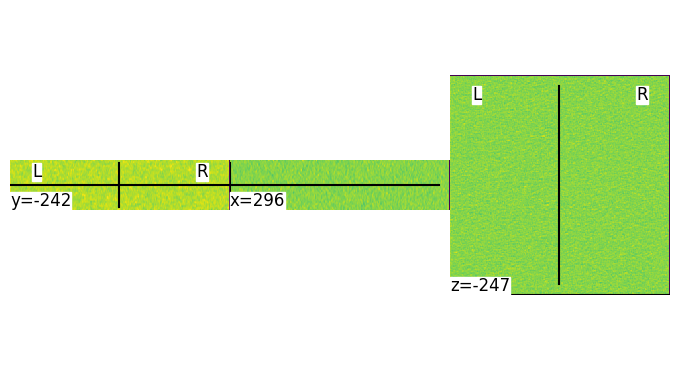

In [ ]:
import matplotlib.pyplot as plt
from nilearn.plotting import plot_img
loaded_super_resolved_nifti_img2='/content/drive/MyDrive/CTdata/high3 resolution.nii.gz'
nifti_img_5mm_diffusion = nib.load(loaded_super_resolved_nifti_img2)
windowed_conv_5mm2 = apply_windowing(nifti_img_5mm_diffusion.get_fdata(), window_center, window_width)

scaled_conv_5mm2 = min_max_scaling(windowed_conv_5mm2)

# Resample to isotropic voxels
resampled_conv_5mm = resample_image(nib.Nifti1Image(scaled_conv_5mm2, nifti_img_1mm.affine))

plot_img(resampled_conv_5mm)